In [ ]:
pip install fastai

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [16]:
! cp kaggle.json ~/.kaggle/

In [17]:
! chmod 600 ~/.kaggle/kaggle.json

In [18]:
! kaggle datasets download emmarex/plantdisease

 98% 642M/658M [00:05<00:00, 204MB/s]
100% 658M/658M [00:05<00:00, 121MB/s]


In [ ]:
! unzip plantdisease

In [21]:
from fastai import *
from fastai.vision import *
import os
from os import listdir
%reload_ext autoreload
%autoreload 2
%matplotlib inline
path = "/content/plantdisease/PlantVillage"
os.listdir(path)

['Tomato_healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Potato___Late_blight',
 'Pepper__bell___healthy',
 'Tomato_Leaf_Mold',
 'Tomato_Late_blight',
 'Potato___Early_blight',
 'Tomato_Early_blight',
 'Pepper__bell___Bacterial_spot',
 'Tomato__Target_Spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Potato___healthy',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__Tomato_YellowLeaf__Curl_Virus']

In [22]:
directory_root = '/content/plantdisease'
image_list, label_list = [], []

In [23]:
try:
    print("Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(image_directory)
                    label_list.append(plant_disease_folder)
    print("Image loading completed")
except Exception as e:
    print(f"Error : {e}")

Loading images ...
Processing Tomato_healthy ...
Processing Tomato_Bacterial_spot ...
Processing Tomato_Septoria_leaf_spot ...
Processing Potato___Late_blight ...
Processing Pepper__bell___healthy ...
Processing Tomato_Leaf_Mold ...
Processing Tomato_Late_blight ...
Processing Potato___Early_blight ...
Processing Tomato_Early_blight ...
Processing Pepper__bell___Bacterial_spot ...
Processing Tomato__Target_Spot ...
Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
Processing Potato___healthy ...
Processing Tomato__Tomato_mosaic_virus ...
Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
Processing PlantVillage ...
Image loading completed


In [24]:
from fastai.vision.all import *

tfms = aug_transforms(flip_vert=True, max_warp=0., max_zoom=0., max_rotate=0.)

In [25]:
file_path = '/content/plantdisease/PlantVillage/Potato___Early_blight/0faca7fe-7254-4dfa-8388-bbc776338c9c___RS_Early.B 7929.JPG'
dir_name = os.path.dirname(file_path)

In [26]:
dir_length = len(dir_name.split("/"))
dir_name.split("/")

['', 'content', 'plantdisease', 'PlantVillage', 'Potato___Early_blight']

In [27]:
dir_name.split("/")[dir_length - 1]

'Potato___Early_blight'

In [28]:
def get_labels(file_path):
    dir_name = os.path.dirname(file_path)
    split_dir_name = dir_name.split("/")
    dir_length = len(split_dir_name)
    label  = split_dir_name[dir_length - 1]
    return(label)

In [29]:
data = ImageDataLoaders.from_path_func(path, image_list, label_func=get_labels,
                                       size=224,bs=64,num_workers=2,
                                       ds_tfms=tfms,batch_size=12)

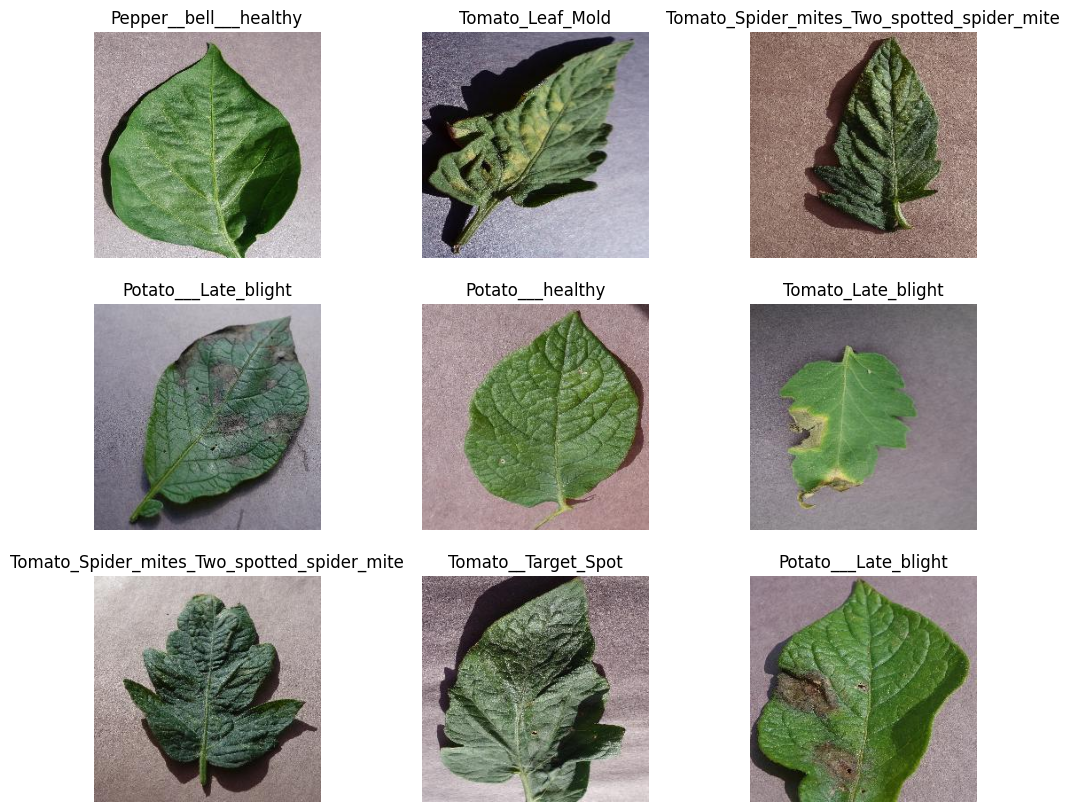

In [30]:
data.show_batch(figsize=(12,10))

In [31]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, model_dir='/tmp/models/')

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 139MB/s]


In [32]:
learn.fit_one_cycle(10)

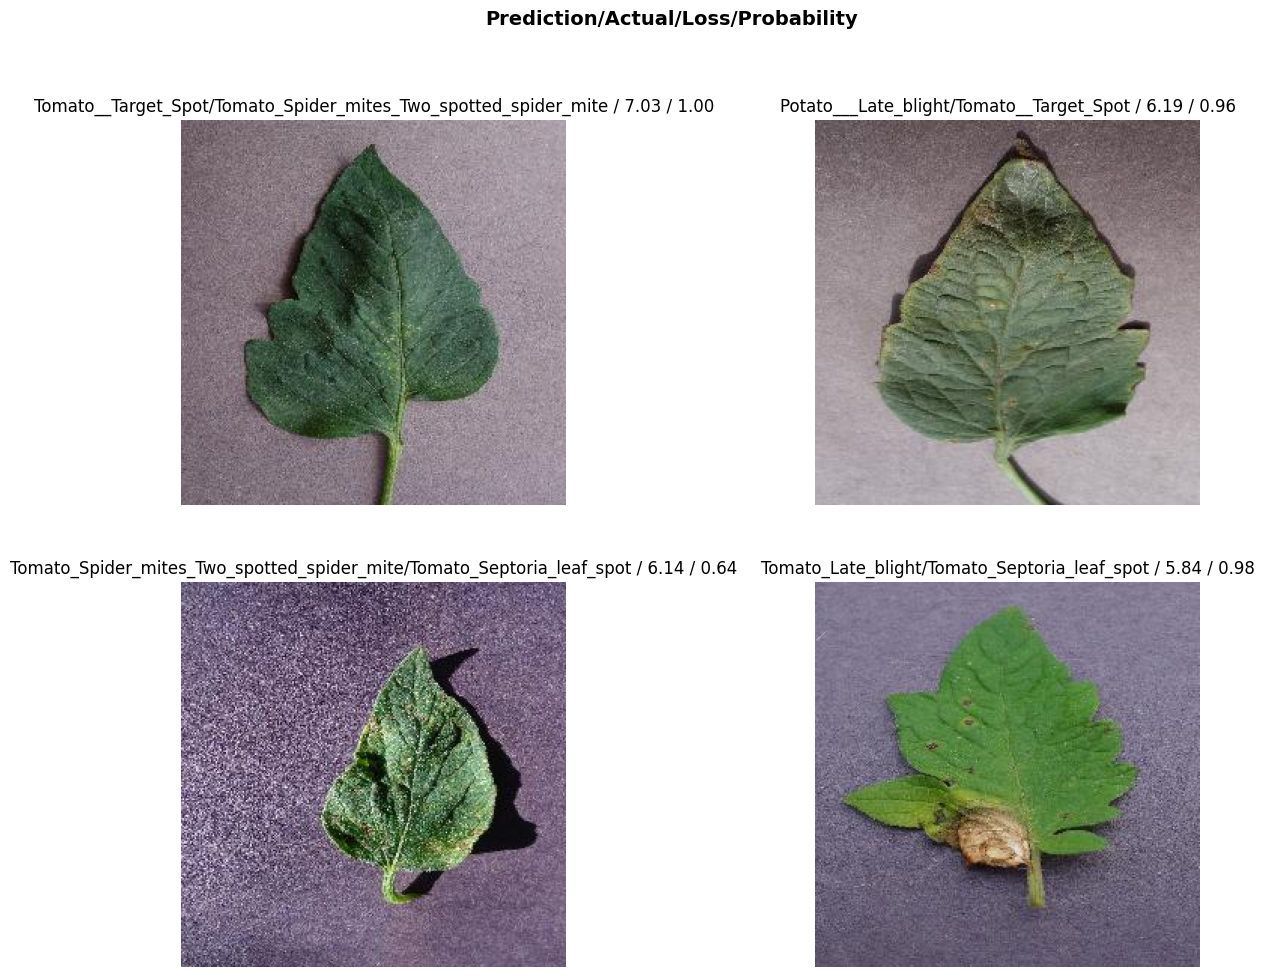

In [41]:
interpretation = ClassificationInterpretation.from_learner(learn)
losses, indices = interpretation.top_losses()
interpretation.plot_top_losses(4, figsize=(15,11))

In [50]:
learn.fine_tune(5)

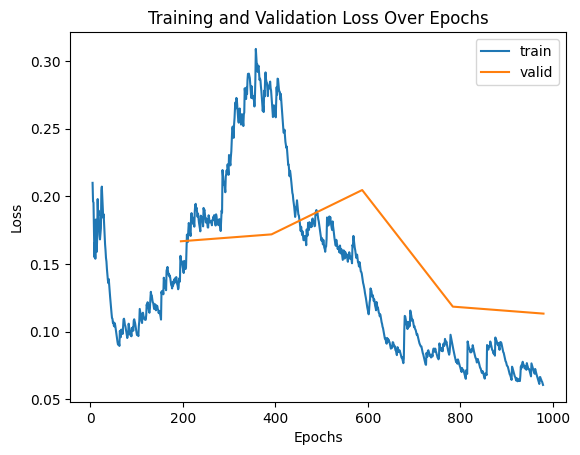

In [53]:
learn.recorder.plot_loss()
import matplotlib.pyplot as plt

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

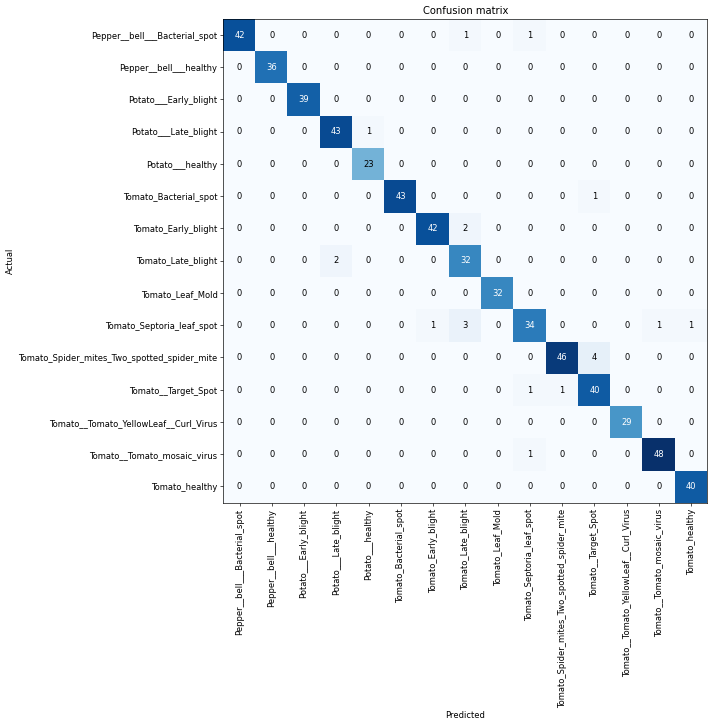

In [54]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [55]:
interpretation.most_confused(min_val=2)

[('Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 4),
 ('Tomato_Septoria_leaf_spot', 'Tomato_Late_blight', 3),
 ('Tomato_Early_blight', 'Tomato_Late_blight', 2),
 ('Tomato_Late_blight', 'Potato___Late_blight', 2)]

In [56]:
learn.save('classification-1')
learn.unfreeze()
learn.fit_one_cycle(1)

SuggestedLRs(valley=3.0199516913853586e-05)

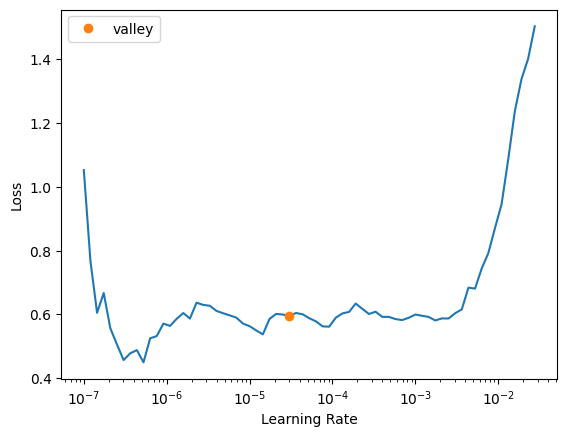

In [57]:
learn.lr_find()

In [64]:
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-4))

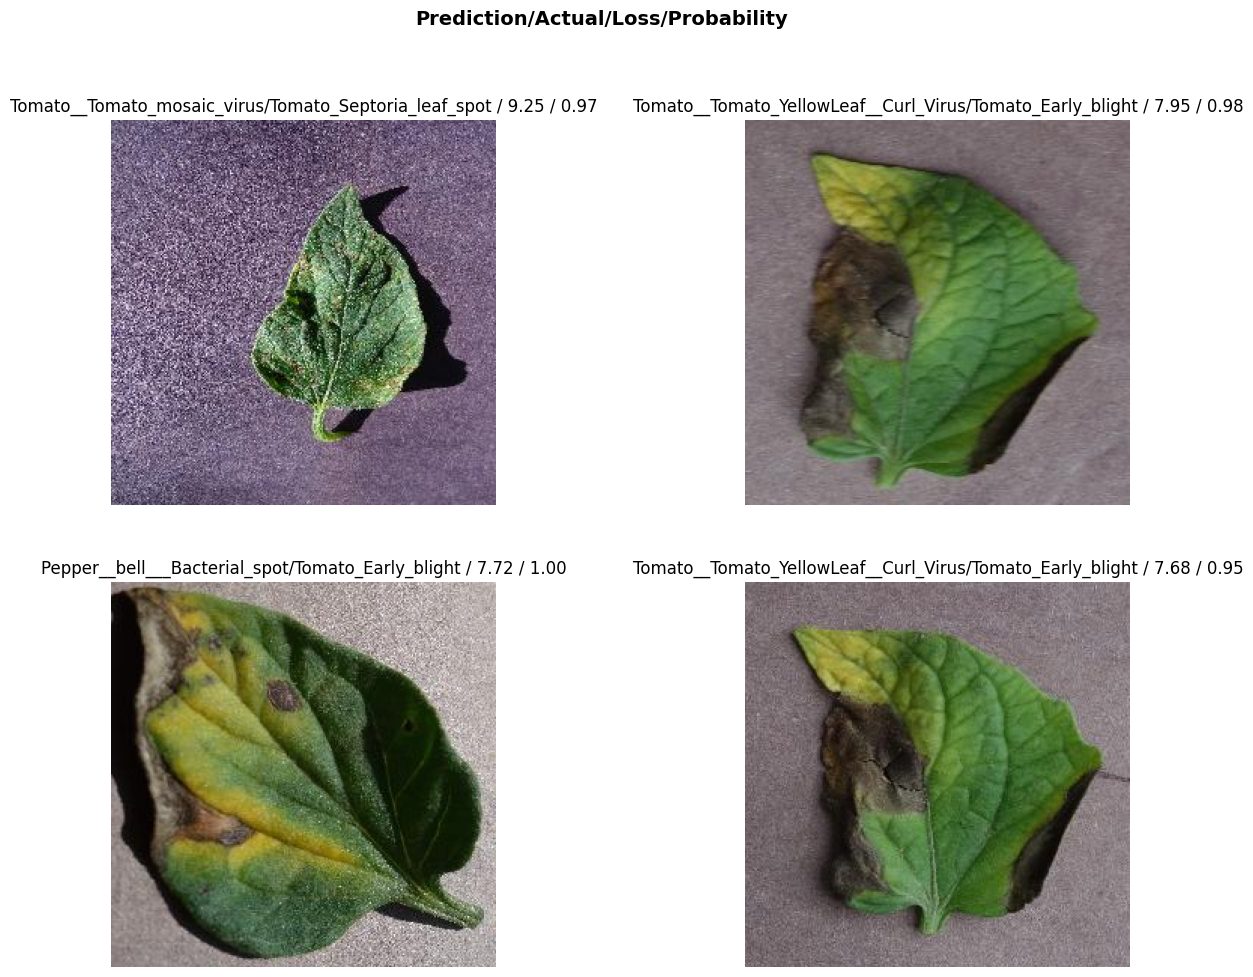

In [65]:
interpretation = ClassificationInterpretation.from_learner(learn)
losses, indices = interpretation.top_losses()
interpretation.plot_top_losses(4, figsize=(15,11))

In [66]:
interpretation.most_confused(min_val=2)

[('Tomato_Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 5),
 ('Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 3),
 ('Potato___Late_blight', 'Potato___healthy', 2),
 ('Tomato_Bacterial_spot', 'Tomato_Early_blight', 2),
 ('Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 2),
 ('Tomato_Late_blight', 'Potato___Late_blight', 2),
 ('Tomato_Septoria_leaf_spot', 'Tomato_Late_blight', 2),
 ('Tomato_Septoria_leaf_spot', 'Tomato__Tomato_mosaic_virus', 2)]